In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import DatetimeIndex
import datetime

# !pip install yfinance
import yfinance as yf

import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.anova import anova_lm

In [2]:
print('Sample Data','\n')
print('Tickers - VOO, VEU, AGG, IGOV, DBO')
print('Start 2010-12-31')
print('End Date 2020-12-31','\n')

print('Enter Start Date in yyyy-mm-dd')
start_date = input()
print('Enter End Date in yyyy-mm-dd')
end_date = input()
print('Enter US Equity ETF Ticker')
US_E = input()
print('Enter international Equity ETF Ticker')
Int_E = input()
print('Enter US Bond ETF Ticker')
US_B = input()
print('Enter International Bond ETF Ticker')
Int_B = input()
print('Enter Commodity ETF Ticker')
Com = input()
portforlio_user_weights = []
print('Enter the weight for US Equity ETF (decimal form)')
portforlio_user_weights.append(float(input()))
print('Enter the weight for International Equity ETF (decimal form)')
portforlio_user_weights.append(float(input()))
print('Enter the weight for US Bond ETF (decimal form)')
portforlio_user_weights.append(float(input()))
print('Enter the weight for International Bond ETF (decimal form)')
portforlio_user_weights.append(float(input()))
print('Enter the weight for Commodity ETF (decimal form)')
portforlio_user_weights.append(float(input()))

Sample Data 

Tickers - VOO, VEU, AGG, IGOV, DBO
Start 2010-12-31
End Date 2020-12-31 

Enter Start Date in yyyy-mm-dd
2010-12-31
Enter End Date in yyyy-mm-dd
2020-12-31
Enter US Equity ETF Ticker
VOO
Enter international Equity ETF Ticker
VEU
Enter US Bond ETF Ticker
AGG
Enter International Bond ETF Ticker
IGOV
Enter Commodity ETF Ticker
DBO
Enter the weight for US Equity ETF (decimal form)
0.3
Enter the weight for International Equity ETF (decimal form)
0.25
Enter the weight for US Bond ETF (decimal form)
0.2
Enter the weight for International Bond ETF (decimal form)
0.15
Enter the weight for Commodity ETF (decimal form)
0.1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

             Expected Return     SD  Sharpe Ratio  Maximum Drawdown  \
us_equity             14.30  17.39          0.82              0.76   
int_equity             6.14  18.68          0.33              0.52   
us_bond                3.81   4.01          0.95              0.32   
int_bond               2.07   7.80          0.27              0.22   
oil                   -8.33  29.78         -0.28              0.84   

            % High Volatility Days  
us_equity                    12.56  
int_equity                   16.10  
us_bond                       0.20  
int_bond                      1.19  
oil                          35.06  


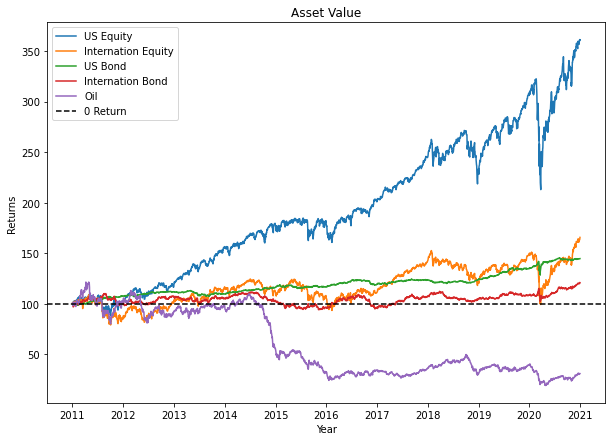

In [38]:
portfolio = pd.DataFrame(columns = ['us_equity','int_equity','us_bond','int_bond','oil'])

portfolio['us_equity'] = yf.download(US_E, start= start_date ,end = end_date, interval = '1d')['Adj Close']
portfolio['int_equity'] = yf.download(Int_E, start= start_date ,end = end_date, interval = '1d')['Adj Close']
portfolio['us_bond'] = yf.download(US_B, start= start_date ,end = end_date, interval = '1d')['Adj Close']
portfolio['int_bond'] = yf.download(Int_B, start= start_date ,end = end_date, interval = '1d')['Adj Close']
portfolio['oil'] = yf.download(Com, start= start_date ,end = end_date, interval = '1d')['Adj Close']
# portfolio['riskfree'] = yf.download('^IRX', start= start_date ,end = end_date, interval = '1d')['Adj Close']

returns = portfolio.pct_change().dropna() + 1

# portfolio.head()

returns.to_excel("returns.xlsx")
returns = pd.read_excel("returns.xlsx")[['Date','us_equity', 'int_equity', 'us_bond', 'int_bond', 'oil']]
returns.set_index('Date', inplace = True)
# returns.head()

# Yearly Returns
yearly_return = returns.groupby([returns.index.year]).prod()-1
# print(round(yearly_return*100,2),'\n')

Asset_Metrics = pd.DataFrame(data = round(yearly_return.mean()*100,2).values, index = yearly_return.mean().index, columns = ['Expected Return'])
Asset_Metrics['SD'] = round(returns.std()*math.sqrt(252)*100,2)
Asset_Metrics['Sharpe Ratio'] = round(yearly_return.mean()/(returns.std()*math.sqrt(252)),2)
Asset_Metrics['Maximum Drawdown'] = round((portfolio.max() - portfolio.min() ) / portfolio.max(),2)
Asset_Metrics['% High Volatility Days'] = round(100*returns[abs(returns.pct_change()) > 0.02].count()/len(returns),2)
print('\n',Asset_Metrics)

# # Yearly return Standard Deviation
# print('Annual Standard Deviation')
# print(round(returns.std()*math.sqrt(252)*100,2),'\n\n')

# # Sharp Ratio (assuming riskfree rate is zero)
# print('Sharpe Ratio')
# print(yearly_return.mean()/(returns.std()*math.sqrt(252)),'\n\n')

# # Maximum Drawdown
# print('Maximum Drawdown')
# print((portfolio.max() - portfolio.min() ) / portfolio.max(),'\n\n')

# # % of trading days where daily change/return was over +/- 2%
# print('% Days of high volatility (greated than 2% change)')
# print(100*returns[abs(returns.pct_change()) > 0.02].count()/len(returns),'\n\n')

plt.rcParams["figure.figsize"] = (10,7)

plt.plot(returns.cumprod()*100, marker = None)
plt.axhline(y=100, color='black', linestyle='--')
plt.legend(['US Equity','Internation Equity','US Bond', 'Internation Bond', 'Oil','0 Return'],loc = 'upper left')
plt.title('Asset Value')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.show()

In [39]:
## Portfolio Return with Monthly Rebalancing

# Finding 1st trading day of every month
test = portfolio.copy()
test.reset_index(inplace=True)
test['year'] = pd.DatetimeIndex(test['Date']).year
test['month'] = pd.DatetimeIndex(test['Date']).month
test['day'] = pd.DatetimeIndex(test['Date']).day
test2 = test[['year','month','day']].groupby(['year', 'month']).min().reset_index()
test2['date_of_adjustment']=pd.to_datetime(test2[['year','month','day']])
rebalance_date = pd.DatetimeIndex(test2['date_of_adjustment'])


# Rebalancing Algo

def portfolio_monthly_rebalancing_outputs(portforlio_user_weights):
    
    portfolio_weight = pd.DataFrame(columns=returns.columns.values, index=returns.index).fillna(0.00)
    portfolio_value = pd.DataFrame(columns=['portfolio_value'], index=returns.index).fillna(0.00)
    

    for i in range(len(returns)):

        if i == 0:
            portfolio_weight.iloc[i] = portforlio_user_weights

        if returns.index[i] in (rebalance_date):
            portfolio_weight.iloc[i] = portforlio_user_weights

        else:
            portfolio_weight.iloc[i] = (returns.iloc[i-1] * portfolio_weight.iloc[i-1])/sum(returns.iloc[i-1] * portfolio_weight.iloc[i-1] )

    
    for i in range(len(returns)):

        if i == 0:
            portfolio_value.loc[portfolio_value.index[i],'portfolio_value'] = sum(returns.iloc[i]*portforlio_user_weights)*100
            
        else:
            money_at_start = portfolio_value.loc[portfolio_value.index[i-1],'portfolio_value']
            portfolio_weight_day_start = portfolio_weight.loc[portfolio_weight.index[i]]
            return_for_the_day = returns.loc[returns.index[i]][['us_equity','int_equity','us_bond','int_bond','oil']]
            portfolio_value.loc[portfolio_value.index[i],'portfolio_value'] = money_at_start*sum(portfolio_weight_day_start*return_for_the_day)
        

    expected_return = portfolio_value.resample('Y').last().pct_change().mean().values
    annual_sd = np.sqrt(252)*np.sqrt((portfolio_value.pct_change()).var()).values
    
    portfolio_output = pd.DataFrame(columns = ['values'], index=['Expected','SD','Sharpe Ratio', 'Drawdown', 'Greater than 2% change trading days'] ).fillna(0.00)
    
    portfolio_output.loc['Expected','values'] = expected_return*100
    portfolio_output.loc['SD','values'] = annual_sd*100
    portfolio_output.loc['Sharpe Ratio','values'] = expected_return/annual_sd
    portfolio_output.loc['Drawdown','values'] = (float(portfolio_value.max()) - float(portfolio_value.min()) )/(float(portfolio_value.max()))
    portfolio_output.loc['Greater than 2% change trading days','values'] = 100*float(portfolio_value[abs(portfolio_value.pct_change())>0.02].count())/len(portfolio_value)
            
    return portfolio_output, portfolio_value

                                        values
Expected                              6.798582
SD                                   11.328338
Sharpe Ratio                          0.600139
Drawdown                              0.476392
Greater than 2% change trading days   1.550079


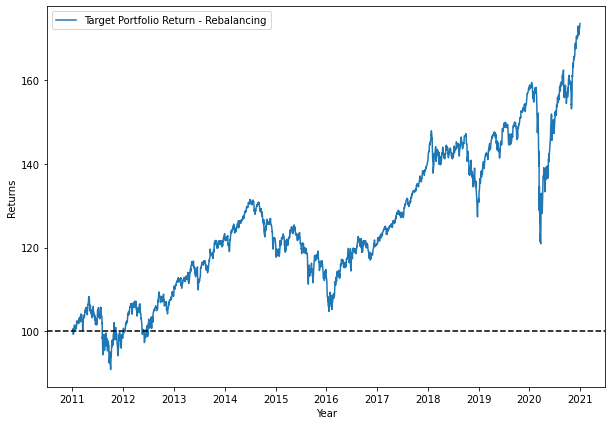

In [40]:
portforlio_user_weights = [0.30,0.25,0.20,0.15,0.10] 
portfolio_output, portfolio_value1 = portfolio_monthly_rebalancing_outputs(portforlio_user_weights)
print(portfolio_output)
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(portfolio_value1, marker = None)
plt.axhline(y=100, color='black', linestyle='--')
plt.legend(['Target Portfolio Return - Rebalancing'],loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.show()

In [44]:
### MPT

Number_of_portfolios = 10000
MPT_weights = pd.DataFrame(columns = returns.columns.values, index = list(range(Number_of_portfolios)) ).fillna(0.00)

for i in range(Number_of_portfolios):
    
    x = np.random.dirichlet(np.ones(5),size=1)
    
    while x.max() > 0.45:
        x =  np.random.dirichlet(np.ones(5),size=1)
    
    MPT_weights.loc[i] = x
    
port_return = []
port_sd = []

variance_matrix = returns.cov()*252    

In [45]:
asset_class_returns = yearly_return.mean()

for i in range(len(MPT_weights)):
    ind_port_return = np.dot(MPT_weights.iloc[i], asset_class_returns*100)
    port_return.append(ind_port_return)
    
    variance = variance_matrix.mul(MPT_weights.iloc[i], axis = 0).mul(MPT_weights.iloc[i], axis = 1).sum().sum()
    sd = np.sqrt(variance)*np.sqrt(252)
    port_sd.append(sd)
    
MPT_weights['return'] = port_return
MPT_weights['sd'] = port_sd

In [46]:
# optimal_risky_portfolio - Max Sharpe Ratio
rf = 0.05

optimal_risky_portfolio = MPT_weights.iloc[( (MPT_weights['return'] - rf)/MPT_weights['sd']).idxmax()]

# Min Risk Portfolio
min_risk = MPT_weights.iloc[MPT_weights['sd'].idxmin()]

# Max Return Portfolio
max_return = MPT_weights.iloc[MPT_weights['return'].idxmax()]

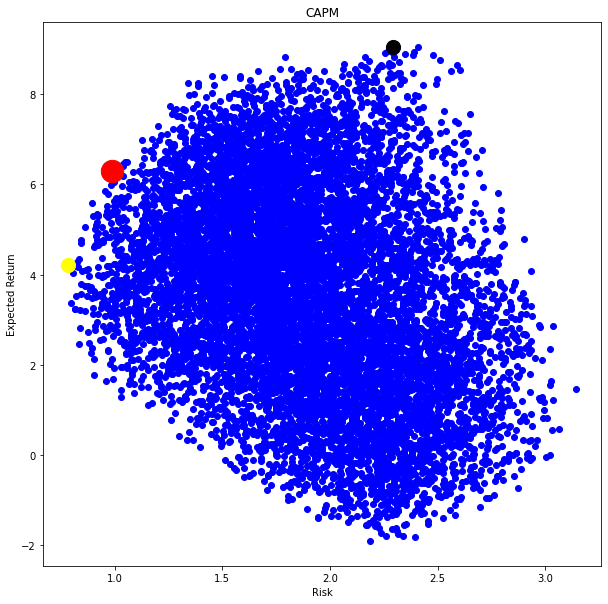

In [47]:
plt.subplots(figsize=[10,10])

plt.scatter(MPT_weights['sd'], MPT_weights['return'], color = 'blue', marker = 'o')

plt.scatter(optimal_risky_portfolio['sd'],optimal_risky_portfolio['return'], s=500, color = 'red', marker = 'o',label = 'Max Sharpe Ratio Portfolio')
plt.scatter(min_risk['sd'],min_risk['return'], color = 'yellow', s=200, marker = 'o',label = 'Minimum Risk Portfolio')
plt.scatter(max_return['sd'],max_return['return'], color = 'black', s=200, marker = 'o',label = 'Max Return Portfolio')

plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.title('CAPM')
plt.show()

us_equity     0.298212
int_equity    0.002299
us_bond       0.385305
int_bond      0.303494
oil           0.010691
return        6.285997
sd            0.988135
Name: 69, dtype: float64 


Retuns on Sharpe Ratio Portfolio with Monthly Rebalancing using the end Weights
                                       values
Expected                             6.505136
SD                                   6.121027
Sharpe Ratio                         1.062752
Drawdown                             0.454175
Greater than 2% change trading days  0.357711


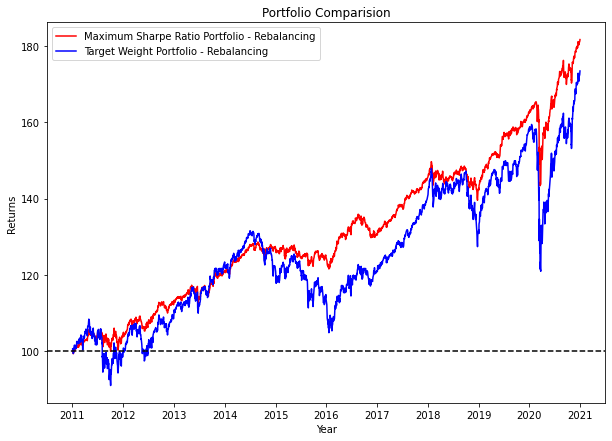

In [48]:
#  Max Sharpe Ratio Portfolio
print(optimal_risky_portfolio,'\n\n')

print('Retuns on Sharpe Ratio Portfolio with Monthly Rebalancing using the end Weights')

portfolio_output, portfolio_value2 = portfolio_monthly_rebalancing_outputs(optimal_risky_portfolio.iloc[:5])
print(portfolio_output)
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(portfolio_value2, marker = None, color = 'Red')
plt.plot(portfolio_value1, marker = None, color = 'Blue')
plt.axhline(y=100, color='black', linestyle='--')
plt.legend(['Maximum Sharpe Ratio Portfolio - Rebalancing', 'Target Weight Portfolio - Rebalancing'],loc = 'upper left')
plt.title('Portfolio Comparision')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.show()